#  [모듈 3.1] Detector 생성
이 노트북은 아래의 원본 노트북의 내용을 기반으로 하였습니다.



# 0. 개념

![detector_dependencies.png](img/detector_dependencies.png)

# 1. 환경 셋업

In [22]:
%store -r project_prefix
%store -r ENTITY_TYPE
%store -r EVENT_TYPE
%store -r MODEL_NAME
%store -r ARN_ROLE
%store -r modelVersionNumber

In [23]:
print("project_prefix: ", project_prefix)
print("ENTITY_TYPE: ", ENTITY_TYPE)
print("EVENT_TYPE: ", EVENT_TYPE)
print("MODEL_NAME: ", MODEL_NAME)
print("modelVersionNumber: ", modelVersionNumber)
print("ARN_ROLE: ", ARN_ROLE)

project_prefix:  adtaking_fraud_phase0
ENTITY_TYPE:  cf_customer_20210912
EVENT_TYPE:  adtaking_fraud_phase0_20210912
MODEL_NAME:  adtaking_fraud_phase0_model_20210912
modelVersionNumber:  1.0
ARN_ROLE:  arn:aws:iam::057716757052:role/AFD-gsmoon


In [24]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

import os
import sys
import time
import json
import uuid 
from datetime import datetime
from IPython.display import display as dp

# -- AWS stuff -- 
import boto3
import sagemaker

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline 

In [25]:
# -- initialize the AFD client 
client = boto3.client('frauddetector')

# -- suffix is appended to detector and model name for uniqueness  
sufx   = datetime.now().strftime("%Y%m%d")


# 2. 훈련된 모델의 성능 평가

## 모델 성능 데이터 가져오기


In [27]:
# -- model performance summary -- 
auc = client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber= modelVersionNumber,
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber= modelVersionNumber,
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


model_stat = df_model.round(decimals=2)  



In [31]:
model_stat.tail(10)

,fpr,precision,tpr,threshold
191,0.01,0.20,0.71,955.0
192,0.01,0.20,0.71,960.0
193,0.01,0.19,0.59,965.0
194,0.00,0.21,0.48,970.0
195,0.00,0.20,0.43,975.0
196,0.00,0.22,0.38,980.0
197,0.00,0.22,0.38,985.0
198,0.00,0.26,0.18,990.0
199,0.00,0.26,0.18,995.0
200,0.00,1.00,0.00,1000.0


## TPR, FPR 의 해석

#### 지표의 의미
- threshold (fraud score)
    - 추론을 하면 fraud score 가 제공이 됩니다. 이를 threshold 로 설정했을 경우에 FPR, Precision, TPR을 계산 합니다.
- FPR (Fasle Positive Rate): Fraud를 잘못 검출하는 비율. 에러라고 보시면 됩니다.
    - threshold 를 낮게 설정하면 이 값이 높아 집니다. 즉 기준을 완화 하였기에 Fraud 를 잘못 검출하는 비율이 늘어나게 됩니다.
- TPR (True Positive Rate): 실제 Fraud 를 검출하는 비율
    - threshold 를 낮게 설정하면 이 값은 늘어 납니다. 즉 기준을 완화 하였기에 Fraud 의 검출은 늘어 나게 됩니다.
- Precision
    - 모델 Fraud 라고 추론 한 것에서 실제 참값이 Fraud 인 것의 비율입니다. 
    - threshold 가 높을 수록 기준이 엄격하기에 Precision 는 높아지고, threshold 가 낮아지면 기준이 낮아져서 Precision는 낮아지게 됩니다.
    
    
#### 아래 성능 해석 의 예시


- threshold 가 980 일 경우
    - TPR (True Positive Rate)
        - 0.71 (71% 임) 
    - FPR (Fasle Positive Rate):
        - 0.01 (1% 임)
        
        
- threshold 가 985 일 경우
    - TPR: 실제 Fraud 를 검출하는 비율
        - 0.47 (47% 임) : 프로드의 기준을 높였기 때문에 프로드의 검출 비율은 낮아짐.
    - FPR:  Fraud를 잘못 검출하는 비율
        - 0.00 (0% 임): 프로드의 검출 기준이 높기 때문에 "에러"는 작아집니다.



```
    fpr	precision	tpr	threshold
194	0.01	0.18	0.76	970.0
195	0.01	0.21	0.76	975.0
196	0.01	0.21	0.71	980.0
197	0.00	0.21	0.47	985.0
198	0.00	0.25	0.31	990.0
199	0.00	0.57	0.09	995.0
200	0.00	1.00	0.00	1000.0

```

- 참고: ROC Curve의 의미 --> [ROC Curve 정의](https://nittaku.tistory.com/297)

## Roc Curve 보이기

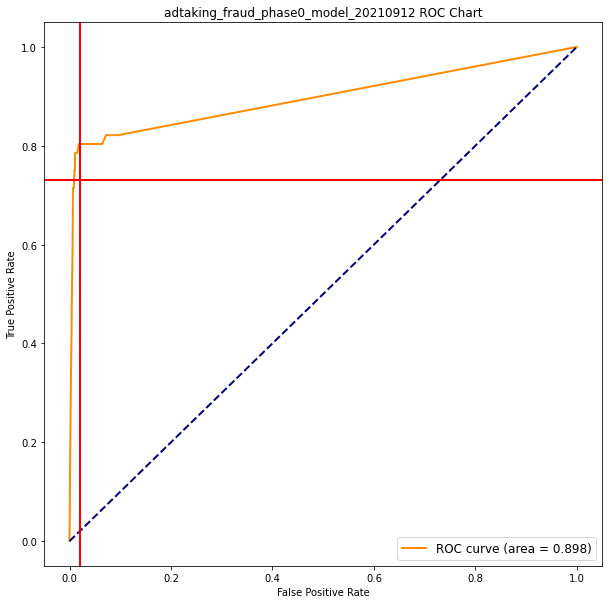

In [32]:
def display_roc_curve(df_model):
    plt.figure(figsize=(10,10))
    plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
             lw=2, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( MODEL_NAME + ' ROC Chart')
    plt.legend(loc="lower right",fontsize=12)
    plt.axvline(x = 0.02 ,linewidth=2, color='r')
    plt.axhline(y = 0.73 ,linewidth=2, color='r')
    plt.show()
    
display_roc_curve(df_model)    

# 3. Rule 생성 작업

## FPR 기준으로 threshold(Score) 높은 값 가져오기

- fpr 이 같은 것으로 그룹을 생성하고, 그룹중에서 가장 Id 값이 큰 것을 가져옴.
    - 아래 예에서는 fpr 0.00 에 대해서 idmax 200번을 선택함
- fpr 의 값이 여러개에서 1개의 값으로 표현이 됨    

`model_stat.groupby(["fpr"])["threshold"].idxmax()]`
```
	fpr	precision	tpr	threshold
196	0.01	0.21	0.71	980.0
197	0.00	0.21	0.47	985.0
198	0.00	0.25	0.31	990.0
199	0.00	0.57	0.09	995.0
200	0.00	1.00	0.00	1000.0
```

In [33]:
m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 
m.head(100)

,fpr,precision,tpr,threshold
200,0.00,1.00,0.00,1000.0
193,0.01,0.19,0.59,965.0
182,0.02,0.11,0.79,910.0
159,0.04,0.04,0.80,795.0
154,0.05,0.04,0.80,770.0
151,0.06,0.03,0.80,755.0
141,0.07,0.03,0.82,705.0
124,0.10,0.02,0.82,620.0
0,1.00,0.00,1.00,0.0


## threshold_prev 값을 추가
- Rule 조건식을 만들기 위해서 이전 threshold 의 값을 가져와서 컬럼에 추가

In [34]:
m["threshold_prev"] = m['threshold'].shift(1)
m.head(10)

,fpr,precision,tpr,threshold,threshold_prev
200,0.00,1.00,0.00,1000.0,NaN
193,0.01,0.19,0.59,965.0,1000.0
182,0.02,0.11,0.79,910.0,965.0
159,0.04,0.04,0.80,795.0,910.0
154,0.05,0.04,0.80,770.0,795.0
151,0.06,0.03,0.80,755.0,770.0
141,0.07,0.03,0.82,705.0,755.0
124,0.10,0.02,0.82,620.0,705.0
0,1.00,0.00,1.00,0.0,620.0


## threshold 파라미터 기준 값 설정

- 모델 추론의 Score 결과를 'Fraud', 'investigate','approve'로 태킹을 하려고 함.
- 이를 위해서 FPR 기준으로 세 개의 분류를 하려고 함.
- 아래는 수치는 바꾸어서 사용하시면 됩니다. 하나의 예로 봐주세요.
    - fraud의 기준을 fpr 기준으로 0.05 이하로 설정
    - investigate 기준을 fpr 기준으로 0.05 보다 초과 하고 0.10 이하로 설정
    - approve 의 기준을 0.11 보다 이상인 것으로 설정
    
#### 각 fpr 의 기준값에 따른 score 값을 확인, 실제 추론의 결과를 이 스코어 값으로 할당하여 세 개로 태킹 함.    



In [35]:
fpr_fraud_threshold = 0.02 # <-- 에러시 수정
fpr_investigate_threshold = 0.05 # <-- 에러시 수정
fpr_approve_threshold = 0.06 # <-- 에러시 수정

#### [에러시] 야래와 같은 에러가 발생할 경우에 위 테이블에서 fpr 이 있는 값으로 변경 해주세요.

![fpr_index_error.png](img/fpr_index_error.png)



In [36]:
score_fraud_threshold = m[m['fpr'] == fpr_fraud_threshold]['threshold'].values[0]
score_investigate_threshold = m[m['fpr'] == fpr_investigate_threshold]['threshold'].values[0]
score_approve_threshold = m[m['fpr'] == fpr_approve_threshold]['threshold'].values[0]
print("score_fraud_threshold: ", score_fraud_threshold)
print("score_investigate_threshold: ", score_investigate_threshold)
print("score_approve_threshold: ", score_approve_threshold)


score_fraud_threshold:  910.0
score_investigate_threshold:  770.0
score_approve_threshold:  755.0


## 각각의 Threshold 에 일괄적으로 Rule Expression 생성
- 위의 fpr_fraud_threshold, fpr_investigate_threshold, fpr_approve_threshold 의 기준에 따라서 Rule 조건식 생성

In [37]:

def make_rule(x, fraud_threshold, investigate_threshold, approve_threshold):
    rule = ""
    threshold_prev = x['threshold_prev']
    threshold = x['threshold']        
    #score_var = f'${MODEL_NAME}_insightscore'
    if x['fpr'] <= fraud_threshold: 
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,x['threshold'])
    if  (x['fpr'] > fraud_threshold)  & (x['fpr'] <= investigate_threshold):

        rule = f"{threshold} <= ${MODEL_NAME}_insightscore  and ${MODEL_NAME}_insightscore <= {threshold_prev}"
        #print(rule)

    if  x['fpr'] >= approve_threshold:
        rule = "${0}_insightscore < {1}".format(MODEL_NAME,x['threshold_prev'])        
        
    return rule


m['rule'] = m.apply(lambda x: make_rule(x, fpr_fraud_threshold, fpr_investigate_threshold, fpr_approve_threshold), axis=1)
m.head(15)



,fpr,precision,tpr,threshold,threshold_prev,rule
200,0.00,1.00,0.00,1000.0,NaN,$adtaking_fraud_phase0_model_20210912_insightscore > 1000.0
193,0.01,0.19,0.59,965.0,1000.0,$adtaking_fraud_phase0_model_20210912_insightscore > 965.0
182,0.02,0.11,0.79,910.0,965.0,$adtaking_fraud_phase0_model_20210912_insightscore > 910.0
159,0.04,0.04,0.80,795.0,910.0,795.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 910.0
154,0.05,0.04,0.80,770.0,795.0,770.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 795.0
151,0.06,0.03,0.80,755.0,770.0,$adtaking_fraud_phase0_model_20210912_insightscore < 770.0
141,0.07,0.03,0.82,705.0,755.0,$adtaking_fraud_phase0_model_20210912_insightscore < 755.0
124,0.10,0.02,0.82,620.0,705.0,$adtaking_fraud_phase0_model_20210912_insightscore < 705.0
0,1.00,0.00,1.00,0.0,620.0,$adtaking_fraud_phase0_model_20210912_insightscore < 620.0


## Outcome 컬럼 생성
- 세 가지 단계로 outcome 컬럼을 생성 합니다.
    - (1) outcome 컬럼에 모두 'approve' 할당
    - (2) fpr_fraud_threshold 기준으로 'fraud' 할당
    - (3) fpr_fraud_threshold 및 fpr_investigate_threshold 기준으로 'investigate' 할당

### (1) 전체를 Approve 할당

In [38]:
m['outcome'] = "approve"
m.head(5)

,fpr,precision,tpr,threshold,threshold_prev,rule,outcome
200,0.00,1.00,0.00,1000.0,NaN,$adtaking_fraud_phase0_model_20210912_insightscore > 1000.0,approve
193,0.01,0.19,0.59,965.0,1000.0,$adtaking_fraud_phase0_model_20210912_insightscore > 965.0,approve
182,0.02,0.11,0.79,910.0,965.0,$adtaking_fraud_phase0_model_20210912_insightscore > 910.0,approve
159,0.04,0.04,0.80,795.0,910.0,795.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 910.0,approve
154,0.05,0.04,0.80,770.0,795.0,770.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 795.0,approve


### (2) FPR (예: 0.03) 이하 기준으로 Outcome을 Fraud로 할당

In [39]:
m.loc[m['fpr'] <= fpr_fraud_threshold, "outcome"] = "fraud"
m.head(10)

,fpr,precision,tpr,threshold,threshold_prev,rule,outcome
200,0.00,1.00,0.00,1000.0,NaN,$adtaking_fraud_phase0_model_20210912_insightscore > 1000.0,fraud
193,0.01,0.19,0.59,965.0,1000.0,$adtaking_fraud_phase0_model_20210912_insightscore > 965.0,fraud
182,0.02,0.11,0.79,910.0,965.0,$adtaking_fraud_phase0_model_20210912_insightscore > 910.0,fraud
159,0.04,0.04,0.80,795.0,910.0,795.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 910.0,approve
154,0.05,0.04,0.80,770.0,795.0,770.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 795.0,approve
151,0.06,0.03,0.80,755.0,770.0,$adtaking_fraud_phase0_model_20210912_insightscore < 770.0,approve
141,0.07,0.03,0.82,705.0,755.0,$adtaking_fraud_phase0_model_20210912_insightscore < 755.0,approve
124,0.10,0.02,0.82,620.0,705.0,$adtaking_fraud_phase0_model_20210912_insightscore < 705.0,approve
0,1.00,0.00,1.00,0.0,620.0,$adtaking_fraud_phase0_model_20210912_insightscore < 620.0,approve


### (3) FPR 특정 값(예: 0.03) 초과 및  특정 값 이하로 Outcome을 investigate  할당

In [40]:
m.loc[(m['fpr'] > fpr_fraud_threshold) & (m['fpr'] <= fpr_investigate_threshold), "outcome"] = "investigate"
m.head(20)

,fpr,precision,tpr,threshold,threshold_prev,rule,outcome
200,0.00,1.00,0.00,1000.0,NaN,$adtaking_fraud_phase0_model_20210912_insightscore > 1000.0,fraud
193,0.01,0.19,0.59,965.0,1000.0,$adtaking_fraud_phase0_model_20210912_insightscore > 965.0,fraud
182,0.02,0.11,0.79,910.0,965.0,$adtaking_fraud_phase0_model_20210912_insightscore > 910.0,fraud
159,0.04,0.04,0.80,795.0,910.0,795.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 910.0,investigate
154,0.05,0.04,0.80,770.0,795.0,770.0 <= $adtaking_fraud_phase0_model_20210912_insightscore and $adtaking_fraud_phase0_model_20210912_insightscore <= 795.0,investigate
151,0.06,0.03,0.80,755.0,770.0,$adtaking_fraud_phase0_model_20210912_insightscore < 770.0,approve
141,0.07,0.03,0.82,705.0,755.0,$adtaking_fraud_phase0_model_20210912_insightscore < 755.0,approve
124,0.10,0.02,0.82,620.0,705.0,$adtaking_fraud_phase0_model_20210912_insightscore < 705.0,approve
0,1.00,0.00,1.00,0.0,620.0,$adtaking_fraud_phase0_model_20210912_insightscore < 620.0,approve


# 4. Outcome 오브젝트 생성

In [41]:
# -- create outcomes -- 
def create_outcomes(outcomes):
    """ create Fraud Detector Outcomes 
    
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = client.put_outcome(
                          name=outcome,
                          description=outcome)

# -- get distinct outcomes 
outcomes = m["outcome"].unique().tolist()
print("outcomes: \n", outcomes)

create_outcomes(outcomes)

outcomes: 
 ['fraud', 'investigate', 'approve']
creating outcome variable: fraud 
creating outcome variable: investigate 
creating outcome variable: approve 


# 5. Detector 생성

In [42]:
DETECTOR_NAME  = f"{project_prefix}_detector_{sufx}"
DETECTOR_DESC  = "detects synthetic fraud events created: {0}".format(sufx) 


# -- initialize your detector -- 
response = client.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

print(response)

{'ResponseMetadata': {'RequestId': '348ba0fd-bfd1-46ba-9a08-526ca534d2a3', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 12 Sep 2021 12:26:35 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '348ba0fd-bfd1-46ba-9a08-526ca534d2a3'}, 'RetryAttempts': 0}}


# 6. Rule 생성

In [43]:
def create_rule_set(m, fpr_fraud_threshold, fpr_investigate_threshold, fpr_approve_threshold):
    rule_set = []
    fraud_exp = m[m['fpr'] == fpr_fraud_threshold][['outcome','rule']].to_dict('records')
    invvestigate_exp = m[m['outcome'] == 'investigate'][['outcome','rule']].to_dict('records')
    approve_exp = m[m['fpr'] == fpr_approve_threshold][['outcome','rule']].to_dict('records')

#     print(fraud_exp[0])
#     print(invvestigate_exp)
#     print(approve_exp[0])    
    rule_set.append(fraud_exp[0])
    for rule_exp in invvestigate_exp:
        rule_set.append(rule_exp)    
    rule_set.append(approve_exp[0])        
    
    return rule_set

rule_set = create_rule_set(m, fpr_fraud_threshold, fpr_investigate_threshold, fpr_approve_threshold)
rule_set    

[{'outcome': 'fraud',
  'rule': '$adtaking_fraud_phase0_model_20210912_insightscore > 910.0'},
 {'outcome': 'investigate',
  'rule': '795.0 <= $adtaking_fraud_phase0_model_20210912_insightscore  and $adtaking_fraud_phase0_model_20210912_insightscore <= 910.0'},
 {'outcome': 'investigate',
  'rule': '770.0 <= $adtaking_fraud_phase0_model_20210912_insightscore  and $adtaking_fraud_phase0_model_20210912_insightscore <= 795.0'},
 {'outcome': 'approve',
  'rule': '$adtaking_fraud_phase0_model_20210912_insightscore < 770.0'}]

In [44]:

rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    print("creating rule: {0}: IF {1} THEN {2}".format(ruleId, rule["rule"], rule['outcome']))
    try:
        response = client.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
    except:
        print("this rule already exists in this detector")

creating rule: rule0_adtaking_fraud_phase0_model_20210912: IF $adtaking_fraud_phase0_model_20210912_insightscore > 910.0 THEN fraud
creating rule: rule1_adtaking_fraud_phase0_model_20210912: IF 795.0 <= $adtaking_fraud_phase0_model_20210912_insightscore  and $adtaking_fraud_phase0_model_20210912_insightscore <= 910.0 THEN investigate
creating rule: rule2_adtaking_fraud_phase0_model_20210912: IF 770.0 <= $adtaking_fraud_phase0_model_20210912_insightscore  and $adtaking_fraud_phase0_model_20210912_insightscore <= 795.0 THEN investigate
creating rule: rule3_adtaking_fraud_phase0_model_20210912: IF $adtaking_fraud_phase0_model_20210912_insightscore < 770.0 THEN approve


In [45]:
# 위에 Rule 삭제시 아래를 실행 하세요.
# for rule in rule_list:
#     response = client.delete_rule(
#         rule= rule                
#     )
#     print(response)



# 7. Detector Version 생성

In [47]:
detector_version ="1"

In [48]:
client.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = rule_list,
    modelVersions = [{"modelId":MODEL_NAME, 
                      "modelType" : "ONLINE_FRAUD_INSIGHTS",
                      "modelVersionNumber" : modelVersionNumber}],
    ruleExecutionMode = 'FIRST_MATCHED'
    )

print("\n -- detector created -- ")
print(response) 



 -- detector created -- 
{'rule': {'detectorId': 'adtaking_fraud_phase0_detector_20210912', 'ruleId': 'rule3_adtaking_fraud_phase0_model_20210912', 'ruleVersion': '1'}, 'ResponseMetadata': {'RequestId': 'a149aa46-5a70-4268-864b-a63ed6f39ab8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 12 Sep 2021 12:26:39 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '137', 'connection': 'keep-alive', 'x-amzn-requestid': 'a149aa46-5a70-4268-864b-a63ed6f39ab8'}, 'RetryAttempts': 0}}


# 8. Detector Version 을 Active 로 변경
- 아래 업데이트는 Status 를 Draft --> Active 로 변환 함.

In [49]:
response = client.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId= detector_version,
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)


 -- detector activated -- 
{'ResponseMetadata': {'RequestId': '9faaf5c0-8dce-4969-8d02-a0b4ee8d6aee', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 12 Sep 2021 12:26:53 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '9faaf5c0-8dce-4969-8d02-a0b4ee8d6aee'}, 'RetryAttempts': 0}}


## 변수 저장

In [52]:
%store DETECTOR_NAME
%store EVENT_TYPE
%store rule_list
%store detector_version

%store score_fraud_threshold
%store score_investigate_threshold
%store score_approve_threshold
%store outcomes

Stored 'DETECTOR_NAME' (str)
Stored 'EVENT_TYPE' (str)
Stored 'rule_list' (list)
Stored 'detector_version' (str)
Stored 'score_fraud_threshold' (float64)
Stored 'score_investigate_threshold' (float64)
Stored 'score_approve_threshold' (float64)
Stored 'outcomes' (list)
